# Moneyball: a linear regression example

## a linear regression example

The book (and later a movie) Moneyball by Michael Lewis tells the story of how the USA baseball team Oakland Athletics in 2002 leveraged the power of data instead of relying on experts.
Better data and better analysis of the data lead to find and use market inefficiencies.

The team was one of the poorest in a period when only rich teams could afford the all-star players (the imbalance in total salaries being something like 4 to 1).
A new ownership in 1995 was improving the team’s wins but in 2001 the loss of 3 key players and budget cuts were bringing a new idea: take a quantitative approach and find undervalued players.

The traditional way to select players was through scouting but Oakland and his general manager Billy Bean (Brad Pitt in the movie…) selected the players based on their statistics without any prejudice. Specifically, his assistant – the Harvard graduate Paul DePodesta looked at the data to find which ones were the undervalued skills.

A huge repository for the USA baseball statistics (called Sabermetrics) is the Lahman’s Baseball Database. This database contains complete batting and pitching statistics from 1871 to present plus fielding statistics, standings, team stats, managerial records, post-season data and more.

## Read baseball data

In [125]:
import pandas as pd

In [126]:
baseball = pd.read_csv("baseball.csv")

In [127]:
baseball.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,NaN,NaN,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,NaN,NaN,162,0.331,0.428
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,NaN,NaN,162,0.335,0.424


In [128]:
baseball.columns

Index(['Team', 'League', 'Year', 'RS', 'RA', 'W', 'OBP', 'SLG', 'BA',
       'Playoffs', 'RankSeason', 'RankPlayoffs', 'G', 'OOBP', 'OSLG'],
      dtype='object')

The feature named ‘W’ is the wins in the season ‘Year’ and the feature ‘Playoffs’ is a boolean value (0 = didn’t make to the playoffs; 1 = did make).

## Subset to only include moneyball years (until 2001)

In [129]:
moneyball = baseball[baseball.Year < 2002]
moneyball.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
330,ANA,AL,2001,691,730,75,0.327,0.405,0.261,0,NaN,NaN,162,0.331,0.412
331,ARI,NL,2001,818,677,92,0.341,0.442,0.267,1,5.0,1.0,162,0.311,0.404
332,ATL,NL,2001,729,643,88,0.324,0.412,0.260,1,7.0,3.0,162,0.314,0.384
333,BAL,AL,2001,687,829,63,0.319,0.380,0.248,0,NaN,NaN,162,0.337,0.439
334,BOS,AL,2001,772,745,82,0.334,0.439,0.266,0,NaN,NaN,161,0.329,0.393


In [130]:
moneyball[['Team','Year','W','Playoffs']].head()

,Team,Year,W,Playoffs
330,ANA,2001,75,0
331,ARI,2001,92,1
332,ATL,2001,88,1
333,BAL,2001,63,0
334,BOS,2001,82,0


## The goal: make to the playoffs

The first step was to understand what was needed for the team to enter the playoffs and he judged from the past seasons that it takes 95 wins to be reasonably sure to make to the playoffs.

![wins](wins.png)

In [131]:
import matplotlib.pyplot as plt
%matplotlib inline

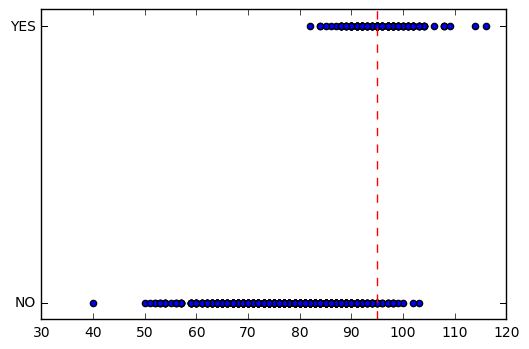

In [132]:
my_yticks=['NO', 'YES']
plt.yticks(moneyball.Playoffs, my_yticks)
plt.scatter(moneyball.W, moneyball.Playoffs)
plt.axvline(x=95, color='r', linestyle='dashed')

Note: you might ask why the goal is to make to the playoff and not directly to win the world series.  
The reason is because the A's managers see their job as making sure the team makes it to the playoffs – after that all bets are off.  

> “Over a long season the luck evens out, and the skill shines through. But in a series of three out of five, or even four out of seven, anything can happen.”

## The goal: make 95 wins 

95 Wins are necessary to be relatively sure to go to the playoffs.  
But how many Runs are then needed?

### Compute Run Difference

To win games a team needs to score more “runs” than their opponent but how many? DePodesta used linear regression to find out. We can see how.

The feature ‘RS’ is the number of runs scored and ‘RA’ is the number of runs allowed.
We can add an additional feature which summarise both of them by calculating the difference:

In [133]:
moneyball = moneyball.assign(RD = moneyball.RS - moneyball.RA)
moneyball.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG,RD
330,ANA,AL,2001,691,730,75,0.327,0.405,0.261,0,NaN,NaN,162,0.331,0.412,-39
331,ARI,NL,2001,818,677,92,0.341,0.442,0.267,1,5.0,1.0,162,0.311,0.404,141
332,ATL,NL,2001,729,643,88,0.324,0.412,0.260,1,7.0,3.0,162,0.314,0.384,86
333,BAL,AL,2001,687,829,63,0.319,0.380,0.248,0,NaN,NaN,162,0.337,0.439,-142
334,BOS,AL,2001,772,745,82,0.334,0.439,0.266,0,NaN,NaN,161,0.329,0.393,27


### Wins are directly correlated with Runs scored

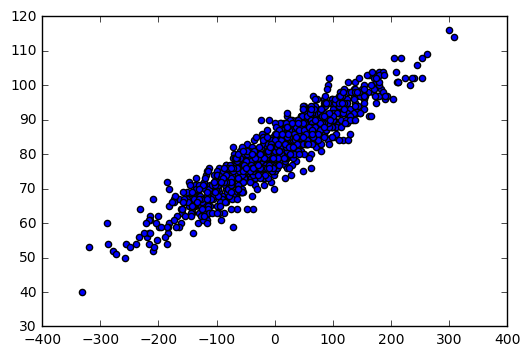

In [134]:
plt.scatter(moneyball.RD, moneyball.W)

The next step is to formalise the relation between Wins and Runs.

Our output would be the number of wins W and we want to see how it depends on the runs difference RD:

W = beta0 + beta1 * RD

This is a linear regression and the beta parameters can be estimated

# Regression model to predict wins

we use the sklearn library and its linear_model module 

In [135]:
from sklearn import linear_model

In [136]:
WinsModel = linear_model.LinearRegression()

The input variable is the Runs Difference, and the output is the Wins

In [137]:
features = moneyball[['RD']]  # input
features.insert(0, 'intercept', 1)

In [138]:
WinsModel.fit(features, moneyball.W)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

To see the fitted beta parameters we can examine the following values:

In [139]:
WinsModel.intercept_

80.881374722838132

In [140]:
WinsModel.coef_

array([ 0.        ,  0.10576562])

Therefore the prediction formula for the number of wins is:  
Wins = 80.9042 + 0.1045 * RD  

To get the number of Runs necessary we need to solve this simple equation:  
95 = 80.9042 + 0.1045 * RD  
RD = (95-80.9042)/0.1045 = 134.89

135 Runs are necessary for 95 wins.  
We can verify it by predicting the wins for 135 Runs:

In [141]:
WinsModel.predict([[1, 135]])

array([ 95.15973375])

## The goal: score 135+ runs more than opponent

How does a team increase the runs difference (RD)?  
There are two ways: either scoring more runs (RS) or allowing less runs (RA).  

The A’s started using a different method to select players,
 based on their statistics, not on their looks.

Most teams focused on Batting Average (BA): getting on base by hitting the ball.

The A’s discovered that BA was overvalued and two baseball statistics were significantly more important than anything else:  
* On-Base Percentage (OBP)   
Percentage of time a player gets on base (including walks)  
* Slugging Percentage (SLG)  
How far a player gets around the bases on his turn (measures
power)


We can use linear regression to verify which baseball player features are more important tot predict runs.

### Regression model to predict runs scored

In [142]:
RSmodel = linear_model.LinearRegression()
features = moneyball[['OBP', 'SLG', 'BA']]  # input
features.insert(0, 'intercept', 1)
RSmodel.fit(features, moneyball.RS)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [143]:
RSmodel.intercept_

-788.4570470807937

In [144]:
RSmodel.coef_

array([    0.        ,  2917.42140821,  1637.92766577,  -368.96606009])

Note that now the beta parameters are 3, being 3 the input features.

The prediction formula for Scored Runs would be:  
  RS = -788 + 2917 \* OBP + 1638 \* SLG -369 \* BA

The score() function returns the R2 metric for the model:

In [145]:
RSmodel.score(features, moneyball.RS)

0.93020162587862809

Which is very high, almost the maximum.

And if we remove the BA feature?

In [146]:
RSmodel2 = linear_model.LinearRegression()
features = moneyball[['OBP', 'SLG']]  # input
features.insert(0, 'intercept', 1)
RSmodel2.fit(features, moneyball.RS)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [147]:
RSmodel2.score(features, moneyball.RS)

0.92958106080965974

There is almost no difference in the R2 when removing the BA feature.  
A sign that BA is not significant. 

Batting Average (BA) is overvalued  
On Base Percentage (OBP) and Slugging Percentage (SLG) are enough.

In [148]:
RSmodel2.intercept_

-804.62706106223959

In [149]:
RSmodel2.coef_

array([    0.        ,  2737.76802227,  1584.90860546])

### Regression model to predict runs allowed

Predicting the Runs Allowed is more difficult because there are missing values in the data:

In [150]:
moneyball.isnull().sum()

Team              0
League            0
Year              0
RS                0
RA                0
W                 0
OBP               0
SLG               0
BA                0
Playoffs          0
RankSeason      748
RankPlayoffs    748
G                 0
OOBP            812
OSLG            812
RD                0
dtype: int64

In [151]:
moneyball.shape

(902, 16)

Out of 902 rows, 812 misses the OOBP and OSLG features that would be critical for RA prediction.

Just for exercise, we can go on but results will not be significant.

There are too many missing values to use the average values instead, better to ignore these rows altogether.

In [152]:
import numpy as np

In [153]:
moneyball = moneyball[np.isfinite(moneyball['OOBP'])]

In [154]:
moneyball = moneyball[np.isfinite(moneyball['OSLG'])]

In [155]:
moneyball.shape

(90, 16)

Now the data set is reduced to 90 rows ...

In [156]:
RAmodel = linear_model.LinearRegression()
features = moneyball[['OOBP', 'OSLG']]
features.insert(0, 'intercept', 1)
RAmodel.fit(features, moneyball.RA)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [157]:
RAmodel.intercept_

-837.37788861333513

In [158]:
RAmodel.coef_

array([    0.        ,  2913.59948582,  1514.28595842])

In [159]:
RAmodel.score(features, moneyball.RA)

0.9073132027228662

# 2002 Prediction

We know that the A's Team OBP in 2002 is 0.339 and the Team SLG is 0.430  
How many Runs and Wins can we expect?

We could just put these values in the formula above:

In [160]:
RS = -804.63 + 2737.77*0.339 + 1584.91*0.43
RS

804.9853300000001

Or we can use the handy function predict():

In [161]:
RSmodel2.predict([[1, 0.339, 0.43]])

array([ 804.98699884])

**We predict 805 Runs scored in 2002**

Let's predict also RA even if the model is very weak, just as example.  
We know that Team OOBP in 2002 is 0.307 and Team OSLG is 0.373

In [162]:
RAmodel.predict([[1, 0.307, 0.373]])

array([ 621.92581602])

**Our 2002 prediction is 622 Runs Allowed.**

In reality, Paul Podesta at the A's team used a similar but slightly different approach and predicted 650-670 Runs Allowed.

And finally the number of wins:

In [163]:
WinsModel.predict([[1, (805-622)]])

array([ 100.23648363])

So our prediction for A's team in 2002 is **100 wins in total**, that would be probably enough to access the playoff.

## Final results

These are 2002 final results:  
- Actual runs score were 800 instead of 805  
- Runs allowed were 653 instead of 622 (note the bigger difference)  
- And wins were 103 instead of 100  
  
They made it to the playoffs

Models (even relatively simple models) allow managers to more accurately value players and minimise risk.  
  
Every major league baseball team now has a statistics group.  
Analytics are used in other sports, too.